In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf

# Veri dizinleri
train_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/train"
test_dir = "/kaggle/input/classed-odir5k-splited-into-train-test/test"
img_size = (224, 224)
batch_size = 64

# Veri setlerini yükle
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',  # Etiketleri one-hot encode et
    shuffle=False
)

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast

# Veri artırma (Data Augmentation) katmanları
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])



# Veri setine artırma uygula
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

# Normalizasyon katmanı
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

# Veri setine normalizasyon uygula
train_dataset = train_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)
test_dataset = test_dataset.map(
    lambda x, y: (preprocess_input(x), y)
)

# Veri setlerini performans için optimize et
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 17555 files belonging to 8 classes.
Found 4392 files belonging to 8 classes.


In [7]:
from tensorflow.keras.applications import ResNet50

# ResNet50 modelini yükle
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Model mimarisi
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.element_spec[1].shape[1], activation='softmax')
])

# Modeli derle
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('efficientnetb0_model.keras', save_best_only=True, monitor='val_accuracy')
epochs = 100
# İlk eğitim (transfer öğrenme)
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 255s 898ms/step - accuracy: 0.7037 - loss: 0.9459 - val_accuracy: 0.8591 - val_loss: 0.4070
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 239s 870ms/step - accuracy: 0.8368 - loss: 0.4755 - val_accuracy: 0.8600 - val_loss: 0.3762
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 239s 868ms/step - accuracy: 0.8427 - loss: 0.4321 - val_accuracy: 0.8638 - val_loss: 0.3683
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 240s 873ms/step - accuracy: 0.8451 - loss: 0.4228 - val_accuracy: 0.8632 - val_loss: 0.3603
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 240s 873ms/step - accuracy: 0.8498 - loss: 0.4162 - val_accuracy: 0.8627 - val_loss: 0.3615
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 875ms/step - accuracy: 0.8464 - loss: 0.4123 - val_accuracy: 0.8632 - val_loss: 0.3548
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 874ms/step - accuracy: 0.8535 - loss: 0.4072 - val_accuracy: 0.8627 - val_loss: 0.3563
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 241s 877ms/step - accuracy: 

In [10]:
# Test veri seti üzerinde modeli değerlendir
test_loss, test_accuracy = model.evaluate(test_dataset)

# Sonuçları yazdır
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8656 - loss: 0.3625
Test Loss: 0.3472
Test Accuracy: 0.8627


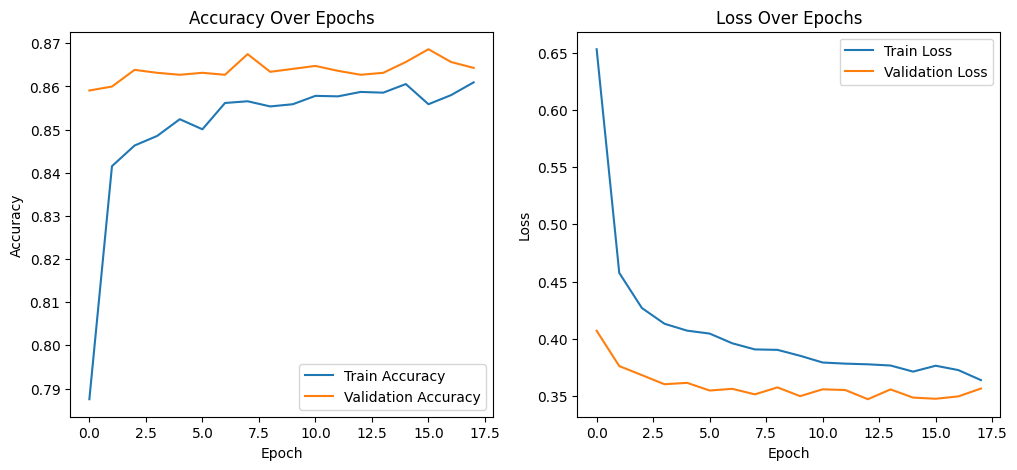

In [9]:
import matplotlib.pyplot as plt

# Accuracy ve loss değerlerini çizdirme
def plot_accuracy_loss(history):
    # Accuracy grafiği
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Grafikleri çizdir
plot_accuracy_loss(history)

Sınıf İsimleri: ['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']
Seçilen Sınıf: D
Seçilen Görsel: /kaggle/input/classed-odir5k-splited-into-train-test/test/D/4369_left.jpg


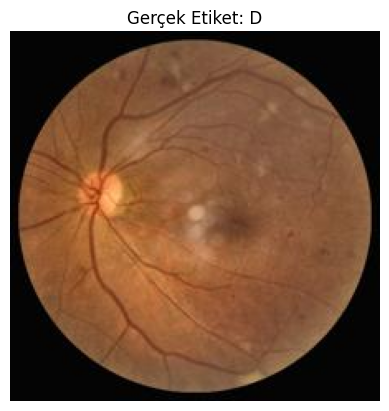

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Gerçek Etiket: D
Tahmin Edilen Etiket: D
Tahmin Olasılıkları: [6.5433286e-02 8.0833532e-04 4.1416442e-01 4.7987243e-03 7.1379855e-02
 2.4392231e-05 2.8796577e-01 1.5542516e-01]


In [47]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Test dizinindeki klasörleri (sınıfları) al
class_names = sorted(os.listdir(test_dir))  # Klasör adlarını al
print("Sınıf İsimleri:", class_names)

# Rastgele bir sınıf seç
random_class = random.choice(class_names)
print("Seçilen Sınıf:", random_class)

# Seçilen sınıftan rastgele bir görsel seç
random_image_path = os.path.join(test_dir, random_class, random.choice(os.listdir(os.path.join(test_dir, random_class))))
print("Seçilen Görsel:", random_image_path)

# Görseli yükle ve ön işleme yap
img = tf.keras.preprocessing.image.load_img(random_image_path, target_size=img_size)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Görseli göster
plt.imshow(img)
plt.title(f"Gerçek Etiket: {random_class}")
plt.axis('off')
plt.show()

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Gerçek Etiket: {random_class}")
print(f"Tahmin Edilen Etiket: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")

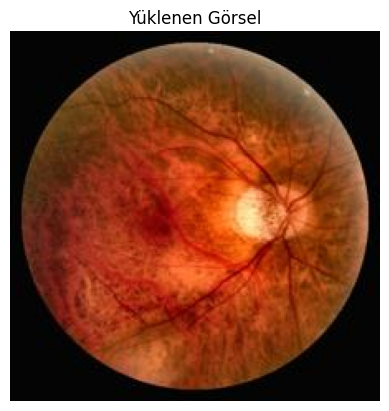

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Tahmin Edilen Sınıf: M
Tahmin Olasılıkları: [2.64078029e-03 1.04165214e-04 2.59574736e-03 3.66400112e-04
 3.71996521e-06 8.97099316e-01 9.36840475e-02 3.50572285e-03]


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Dışarıdan bir görsel yükle
image_path = "/kaggle/input/eski-veri-seti-snf-karm/M/106_right.jpg"  # Görselin yolunu buraya yazın
img = image.load_img(image_path, target_size=(224, 224))  # Görseli 224x224 boyutuna yeniden boyutlandır

# Görseli göster
plt.imshow(img)
plt.title("Yüklenen Görsel")
plt.axis('off')
plt.show()

# Görseli model için hazırla
img_array = image.img_to_array(img)  # Görseli numpy dizisine dönüştür
img_array = np.expand_dims(img_array, axis=0)  # Modelin beklediği şekilde (1, 224, 224, 3)
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Normalizasyon

# Tahmin yap
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions)]  # En yüksek olasılığa sahip sınıf

# Sonucu yazdır
print(f"Tahmin Edilen Sınıf: {predicted_class}")
print(f"Tahmin Olasılıkları: {predictions[0]}")